# Many redundant libraries are loaded, some have different names so need to agree on one and update uses throughout the code

In [1]:
#importing all necessary libraries 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
import numpy as np
import statsmodels.formula.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import time
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from tqdm import tnrange, tqdm_notebook
from sklearn.metrics import (confusion_matrix, 
                           accuracy_score)
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import datasets, metrics, model_selection, svm
from sklearn.metrics import precision_recall_curve

C:\Users\david\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\david\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


## Data quality check / cleaning / preparation 

### Data quality check
*By Jazmyn Lu*

In [2]:
train = pd.read_csv('../train.csv') #taking a quick peek at the data!
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
train.isnull().sum() #there seems to be a lot of missing values of age and cabin

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [4]:
train.shape

(891, 12)

There are only 204 observations for "Cabin", and so it's probably not worth imputing those data points. Moreover, after some preliminary research, I found that Cabins are just divided by Pclass, a variable we already have, so even if we did include it in the model, they would be correlated variables. What may be informative, however, is imputing values of Age. Let's explore that:

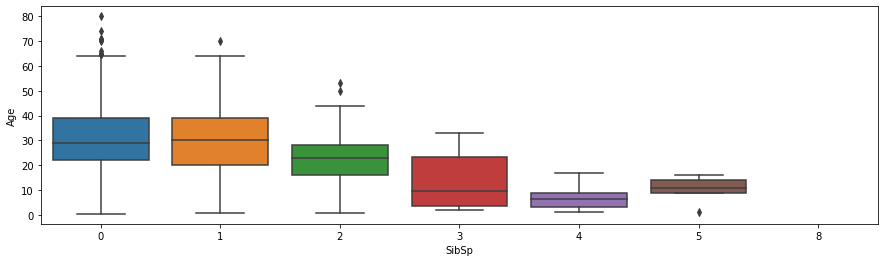

In [5]:
ax = sns.boxplot(x="SibSp", y = 'Age',  data=train)
ax.figure.set_figwidth(15)

Seems like there is a trend where increased number of siblings and spouses means smaller age

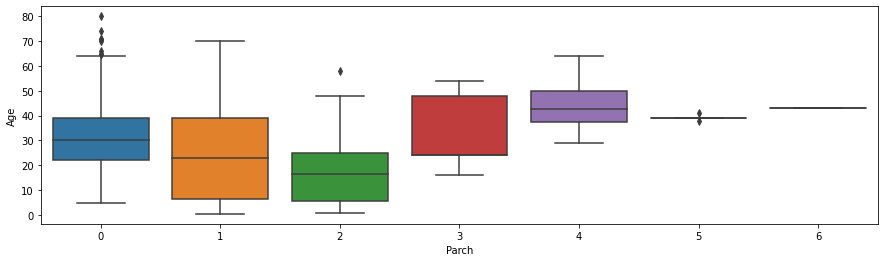

In [6]:
ax = sns.boxplot(x="Parch", y = 'Age',  data=train)
ax.figure.set_figwidth(15)

There also seems to be some correlation

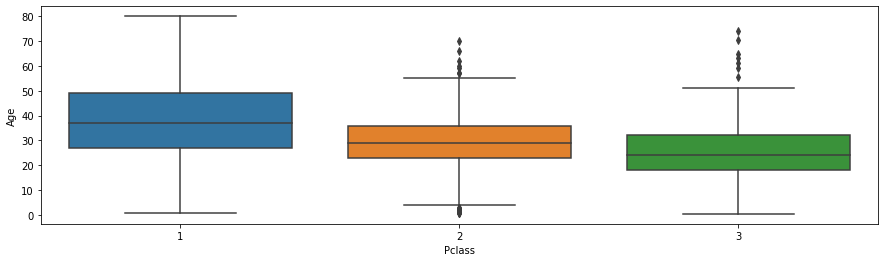

In [7]:
ax = sns.boxplot(x="Pclass", y = 'Age',  data=train)
ax.figure.set_figwidth(15)

Higher class, older people

Text(0.5, 1.0, 'Age vs Fare')

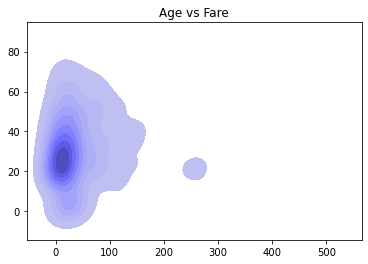

In [8]:
sns.kdeplot(train['Fare'].values, y=train['Age'].values,color='blue',shade=True )
plt.title("Age vs Fare")

Some association between Fare and Age

In [9]:
#PClass, Parch, and SibSp variables are categorical, not numerical. Transform to strings so model treats it as categorical
train['Pclass'] = train['Pclass'].apply(str)
train['Parch'] = train['Parch'].apply(str)
train['SibSp'] = train['SibSp'].apply(str)

In [10]:
missing_age = train[train['Age'].isna()] #dataframe containing only rows missing Age
has_age = train.dropna(subset=['Age']) #dataframe containing only no rows missing Age

ols_object = smf.ols(formula = 'Age~SibSp+Parch+Pclass+Fare', data = has_age) #Making model based on observations
model = ols_object.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    Age   R-squared:                       0.305
Model:                            OLS   Adj. R-squared:                  0.291
Method:                 Least Squares   F-statistic:                     21.94
Date:                Mon, 13 Mar 2023   Prob (F-statistic):           1.16e-46
Time:                        18:14:25   Log-Likelihood:                -2793.2
No. Observations:                 714   AIC:                             5616.
Df Residuals:                     699   BIC:                             5685.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      43.1668      1.359     31.753      0.000      40.498      45.836
SibSp[T.1]     -1.8618      1.142     -1.630      0.104      -4.104       0.380
SibSp[T.2]     -5.7785      2.561     -2.256      0.024     -10.807      -0.750
SibSp[T.3]     -8.3643      3.748     -2.231      0.026     -15.724      -1.005
SibSp[T.4]    -11.6098      3.178     -3.653      0.000     -17.850      -5.370
SibSp[T.5]     -5.1848      5.774     -0.898      0.369     -16.521       6.151
Parch[T.1]     -5.9267      1.393     -4.253      0.000      -8.663      -3.191
Parch[T.2]    -11.8790      1.808     -6.571      0.000     -15.428      -8.330
Parch[T.3]      5.7309      5.548      1.033      0.302      -5.162      16.624
Parch[T.4]     15.6641      6.217      2.520      0.012       3.458      27.870
Parch[T.5]     12.7629      5.548      2.300      0.022       1.870      23.656
Parch[T.6]     17.5979     12.297      1.431      0.153      -6.545      41.741
Pclass[T.2]    -9.8186      1.502     -6.539      0.000     -12.767      -6.870
Pclass[T.3]   -14.9540      1.431    -10.448      0.000     -17.764     -12.144
Fare           -0.0202      0.011     -1.763      0.078      -0.043       0.002
==============================================================================
Omnibus:                       37.930   Durbin-Watson:                   1.873
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.648
Skew:                           0.571   Prob(JB):                     5.48e-10
Kurtosis:                       3.359   Cond. No.                     1.70e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.7e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Text(0, 0.5, 'Residuals')

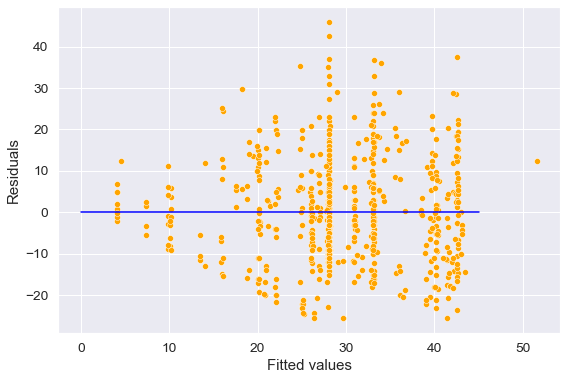

In [11]:
#Checking Model Assumptions

#Plotting residuals vs fitted values
plt.rcParams["figure.figsize"] = (9,6)
sns.set(font_scale=1.25)
ax = sns.scatterplot(x = model.fittedvalues, y=model.resid,color = 'orange')
sns.lineplot(x = [0,45],y = [0,0],color = 'blue')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')

Does not violate non-linearity of data, but there does seem to be non-constant variance of error terms. Take sqrt transformation of Age and see if it resolves this issue:

In [12]:
ols_object = smf.ols(formula = 'np.sqrt(Age)~SibSp+Parch+Pclass+Fare', data = has_age)
model_sqrt_age = ols_object.fit()
model_sqrt_age.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           np.sqrt(Age)   R-squared:                       0.349
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     26.74
Date:                Mon, 13 Mar 2023   Prob (F-statistic):           3.89e-56
Time:                        18:14:25   Log-Likelihood:                -1141.2
No. Observations:                 714   AIC:                             2312.
Df Residuals:                     699   BIC:                             2381.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       6.5176      0.134     48.479      0.000       6.254       6.782
SibSp[T.1]     -0.1719      0.113     -1.522      0.128      -0.394       0.050
SibSp[T.2]     -0.7000      0.253     -2.764      0.006      -1.197      -0.203
SibSp[T.3]     -1.0391      0.371     -2.803      0.005      -1.767      -0.311
SibSp[T.4]     -1.5136      0.314     -4.816      0.000      -2.131      -0.896
SibSp[T.5]     -0.7256      0.571     -1.271      0.204      -1.847       0.395
Parch[T.1]     -0.9035      0.138     -6.556      0.000      -1.174      -0.633
Parch[T.2]     -1.4262      0.179     -7.977      0.000      -1.777      -1.075
Parch[T.3]      0.4934      0.549      0.899      0.369      -0.584       1.571
Parch[T.4]      1.2739      0.615      2.072      0.039       0.067       2.481
Parch[T.5]      1.1880      0.549      2.165      0.031       0.111       2.265
Parch[T.6]      1.5659      1.216      1.288      0.198      -0.822       3.954
Pclass[T.2]    -0.8557      0.149     -5.762      0.000      -1.147      -0.564
Pclass[T.3]    -1.3142      0.142     -9.284      0.000      -1.592      -1.036
Fare           -0.0009      0.001     -0.751      0.453      -0.003       0.001
==============================================================================
Omnibus:                        6.406   Durbin-Watson:                   1.872
Prob(Omnibus):                  0.041   Jarque-Bera (JB):                6.815
Skew:                          -0.162   Prob(JB):                       0.0331
Kurtosis:                       3.352   Cond. No.                     1.70e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.7e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

R-squared improves a bit. Let's check the residuals

Text(0, 0.5, 'Residuals')

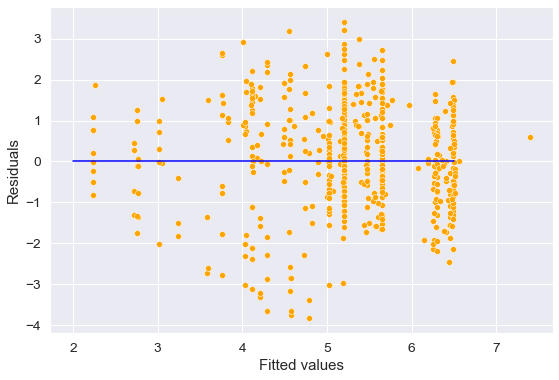

In [13]:
#Plotting residuals vs fitted values
plt.rcParams["figure.figsize"] = (9,6)
sns.set(font_scale=1.25)
ax = sns.scatterplot(x = model_sqrt_age.fittedvalues, y=model_sqrt_age.resid,color = 'orange')
sns.lineplot(x = [2,6.5],y = [0,0],color = 'blue')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')

Better. Not really worth doing any variable transformations since Fare isn't significant in this model anyways, and the rest of the variables are categorical. As a last step, see if we need to remove outliers, high leverage points, and influential points

Text(0, 0.5, 'Studentized Residuals')

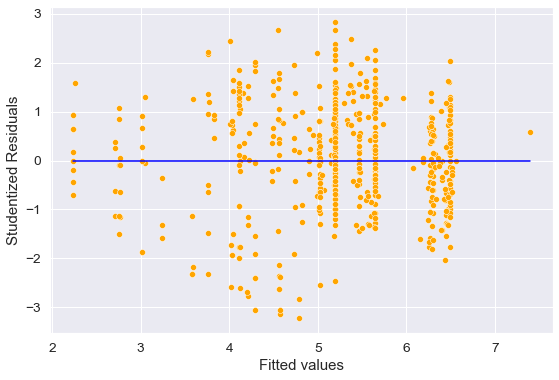

In [14]:
#Studentized residuals
out = model_sqrt_age.outlier_test()
#Plotting studentized residuals vs fitted values
sns.scatterplot(x = (model_sqrt_age.fittedvalues), y=(out.student_resid),color = 'orange')
sns.lineplot(x = [model_sqrt_age.fittedvalues.min(),model_sqrt_age.fittedvalues.max()],y = [0,0],color = 'blue')
plt.xlabel('Fitted values')
plt.ylabel('Studentized Residuals')

In [15]:
influence = model_sqrt_age.get_influence()
leverage = influence.hat_matrix_diag
average_leverage = (model_sqrt_age.df_model+1)/model_sqrt_age.nobs
high_leverage_threshold = 3*average_leverage
np.sum(leverage>high_leverage_threshold)

37

Seems to be 4 outliers (studentized residuals larger than 3) and 37 high leverage points. None of them are influential points

Now we can predict age! In the missing_age dataframe, there are 7 rows where 'SibSp' = 8, but our model which includes people that have age only includes 'SibSp' from 1 to 5. Hence, the model can't fit those values. Maybe we can hand-impute them?

In [16]:
missing_age.loc[missing_age['SibSp']=='8']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


They all seem to come from the same family! Did a little bit of research, and found some information about this family: Stella (born 1891), George John (born 1892), Douglas Bullen (born 1894), Frederick (born 1895), Dorothy Florence (born 1897), Anthony William (born 1899), Elizabeth Ada (born 1901), Constance Gladys (born 1904), Thomas Henry (born 1911). Soure: https://www.nationalarchives.gov.uk/titanic/stories/sage-family.htm

Titanic sunk in 1912\
Thomas: 1\
Constance: 8\
Fredrick: 17\
George: 20\
Stella: 21\
Douglas: 18\
Dorothy: 15

Add these values into "train" dataframe, re-make missing_age and has_age, rerun model, then do prediction!

In [17]:
train.loc[159,'Age']=1
train.loc[180,'Age']=8
train.loc[201,'Age']=17
train.loc[324,'Age']=20
train.loc[792,'Age']=21
train.loc[846,'Age']=18
train.loc[863,'Age']=15
missing_age = train[train['Age'].isna()] #dataframe containing only rows missing Age
has_age = train.dropna(subset=['Age']) #dataframe containing only no rows missing Age
ols_object = smf.ols(formula = 'np.sqrt(Age)~SibSp+Parch+Pclass+Fare', data = has_age)
model_age_final = ols_object.fit()
model_age_final.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           np.sqrt(Age)   R-squared:                       0.354
Model:                            OLS   Adj. R-squared:                  0.341
Method:                 Least Squares   F-statistic:                     25.80
Date:                Mon, 13 Mar 2023   Prob (F-statistic):           2.59e-57
Time:                        18:14:26   Log-Likelihood:                -1152.4
No. Observations:                 721   AIC:                             2337.
Df Residuals:                     705   BIC:                             2410.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       6.5176      0.135     48.454      0.000       6.253       6.782
SibSp[T.1]     -0.1719      0.113     -1.521      0.129      -0.394       0.050
SibSp[T.2]     -0.7000      0.253     -2.762      0.006      -1.198      -0.202
SibSp[T.3]     -1.0391      0.371     -2.802      0.005      -1.767      -0.311
SibSp[T.4]     -1.5136      0.314     -4.813      0.000      -2.131      -0.896
SibSp[T.5]     -0.7256      0.571     -1.270      0.204      -1.847       0.396
SibSp[T.8]     -0.1291      0.494     -0.261      0.794      -1.099       0.841
Parch[T.1]     -0.9035      0.138     -6.553      0.000      -1.174      -0.633
Parch[T.2]     -1.4262      0.179     -7.973      0.000      -1.777      -1.075
Parch[T.3]      0.4934      0.549      0.899      0.369      -0.584       1.571
Parch[T.4]      1.2739      0.615      2.071      0.039       0.066       2.482
Parch[T.5]      1.1880      0.549      2.164      0.031       0.110       2.266
Parch[T.6]      1.5659      1.217      1.287      0.199      -0.823       3.955
Pclass[T.2]    -0.8557      0.149     -5.759      0.000      -1.147      -0.564
Pclass[T.3]    -1.3142      0.142     -9.280      0.000      -1.592      -1.036
Fare           -0.0009      0.001     -0.750      0.453      -0.003       0.001
==============================================================================
Omnibus:                        6.916   Durbin-Watson:                   1.894
Prob(Omnibus):                  0.031   Jarque-Bera (JB):                7.342
Skew:                          -0.173   Prob(JB):                       0.0255
Kurtosis:                       3.353   Cond. No.                     1.71e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.71e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [18]:
missing_age['Age'] = model_age_final.predict(missing_age)**2 #predicting based on dataframe with ages
train_with_age = pd.concat([has_age,missing_age]) #putting two dataframes together

C:\Users\david\AppData\Local\Temp/ipykernel_12568/3789173762.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_age['Age'] = model_age_final.predict(missing_age)**2 #predicting based on dataframe with ages


In [19]:
train_with_age.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Binning Ages:

In [20]:
#Binning Age
binned_age = pd.cut(train_with_age['Age'],8,retbins=True)
train_with_age['age_binned'] = binned_age[0]
age_data = train_with_age.groupby('age_binned')['Survived'].agg([('survival_percent','mean'),('nobs','count')]).reset_index(drop=False)

In [21]:
train_with_age.drop('Cabin',axis=1,inplace=True)
train_with_age.dropna(inplace=True)

## Exploratory data analysis

All of the code done for Exploratory data analysis is already included in the report!

## Variable Selection and Preliminary Analysis

David Venator

In [22]:
train_with_age.dtypes

PassengerId       int64
Survived          int64
Pclass           object
Name             object
Sex              object
Age             float64
SibSp            object
Parch            object
Ticket           object
Fare            float64
Embarked         object
age_binned     category
dtype: object

In [23]:
#Import Statement

import pandas as pd
import numpy as np
import statsmodels.formula.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import time

In [24]:
# train_with_age['SibSp'] = train_with_age['SibSp'].apply(lambda x: int(x))
# train_with_age['Parch'] = train_with_age['Parch'].apply(lambda x: int(x))

In [25]:
#Extract predictors remaining after EDA and preliminary Processing

predictors = train_with_age.columns.tolist()[2:]
X = train_with_age[predictors]

In [26]:
#Perform single variable logistic regression, noting which variables throw errors

to_drop = []
solo = {}
for pred in predictors:
    factor = pred
    try:
        model = sm.logit('Survived~' + factor, data = train_with_age).fit()
        #print(model.pvalues)
        solo[pred] = model
    except:
        to_drop.append(pred)
        print(pred, 'does not model')
        
print(to_drop)

Optimization terminated successfully.
         Current function value: 0.608125
         Iterations 5
Name does not model
Optimization terminated successfully.
         Current function value: 0.515526
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.663820
         Iterations 4
         Current function value: 0.641762
         Iterations: 35
         Current function value: 0.648598
         Iterations: 35


C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1810: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Current function value: inf
         Iterations: 35
Ticket does not model
Optimization terminated successfully.
         Current function value: 0.627274
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.650704
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.652565
         Iterations 5
['Name', 'Ticket']


C:\Users\david\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1863: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


In [27]:
#Check for illogical regressions - pvalues are NaN, or pvalues have an average of 1 (no significance)

for key in list(solo.keys()):
    if solo[key].pvalues.isna().value_counts()[False] < sum(solo[key].pvalues.isna().value_counts()):
        to_drop.append(key)
    elif (solo[key].pvalues > 0.99).mean() == 1:
        to_drop.append(key)

In [28]:
#This shows the columns that either did not regress, or had irregular p-values

print(to_drop)

['Name', 'Ticket']


In [29]:
#Drops these columns from analysis

X = X.drop(columns = to_drop)
for dropped in to_drop:
    if dropped in list(solo.keys()):
        del solo[dropped]

Pclass params are
                     0             1
Intercept    0.515813  2.614685e-04
Pclass[T.2] -0.624616  2.240629e-03
Pclass[T.3] -1.655584  5.728842e-21
Sex params are
                     0             1
Intercept    1.047969  4.834782e-16
Sex[T.male] -2.505089  1.076430e-50
Age params are
                   0         1
Intercept -0.238328  0.150413
Age       -0.008266  0.112114
SibSp params are
                     0             1
Intercept   -0.648914  3.339052e-14
SibSp[T.1]   0.792702  1.149214e-06
SibSp[T.2]   0.505813  1.928958e-01
SibSp[T.3]  -0.449698  4.410116e-01
SibSp[T.4]  -0.960524  1.323208e-01
SibSp[T.5] -21.425465  9.993849e-01
SibSp[T.8] -18.420556  9.971887e-01
Parch params are
                     0             1
Intercept   -0.655657  6.207840e-16
Parch[T.1]   0.859752  2.091348e-05
Parch[T.2]   0.655657  5.842185e-03
Parch[T.3]   1.061122  2.469289e-01
Parch[T.4] -37.658822  9.999997e-01
Parch[T.5]  -0.730638  5.145366e-01
Parch[T.6]  -9.769780  9.575623

C:\Users\david\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\david\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


age_binned params are
                                                            0         1
Intercept                                           0.305382  0.220144
age_binned[T.Interval(10.368, 20.315, closed='r... -0.824175  0.007165
age_binned[T.Interval(20.315, 30.263, closed='r... -1.037921  0.000155
age_binned[T.Interval(30.263, 40.21, closed='ri... -0.489811  0.093363
age_binned[T.Interval(40.21, 50.158, closed='ri... -0.821195  0.010116
age_binned[T.Interval(50.158, 60.105, closed='r... -0.691044  0.084885
age_binned[T.Interval(60.105, 70.052, closed='r... -1.771719  0.009936
age_binned[T.Interval(70.052, 80.0, closed='rig... -1.691676  0.139708


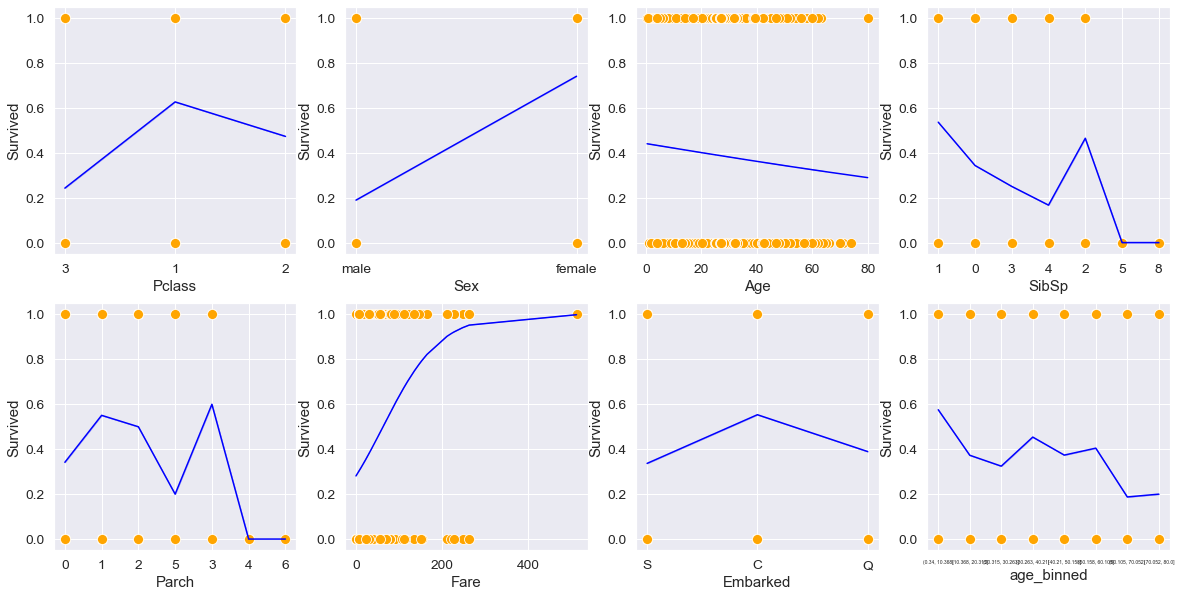

In [30]:
#Plots the single variable regression for all potential predictors after first filter - prints all coeffictients(0) and pvalues(1) for further examiniation

plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

for i in range(len(list(solo.keys()))):
    print(solo[list(solo.keys())[i]])
    plt.subplot(2, 4, i+1)
    if list(solo.keys())[i] == 'age_binned':
        sns.scatterplot(train_with_age[list(solo.keys())[i]].apply(lambda x: str(x)), train_with_age['Survived'], color = 'orange') #Visualizing data
        logit_model = solo[list(solo.keys())[i]]
        print(list(solo.keys())[i], 'params are\n', pd.concat([solo[list(solo.keys())[i]].params, solo[list(solo.keys())[i]].pvalues], axis = 1))
        sns.lineplot(train_with_age[list(solo.keys())[i]].apply(lambda x: str(x)), logit_model.predict(train_with_age), color = 'blue') #Visualizing model
    else: 
        sns.scatterplot(x = list(solo.keys())[i], y = 'Survived', data = train_with_age, color = 'orange') #Visualizing data
        logit_model = solo[list(solo.keys())[i]]
        print(list(solo.keys())[i], 'params are\n', pd.concat([solo[list(solo.keys())[i]].params, solo[list(solo.keys())[i]].pvalues], axis = 1))
        sns.lineplot(x = list(solo.keys())[i], y = logit_model.predict(train_with_age), data = train_with_age, color = 'blue') #Visualizing model
    
plt.xticks(fontsize=5)
plt.savefig('preliminary.png')
    

In [31]:
model_breakers = []

def processSubset(predictor_subset):
    model = sm.logit('Survived~' + '+'.join(predictor_subset),data = train_with_age).fit()
    pval = model.prsquared
    return {"model":model, "llr_pvalue":pval, "vars":predictor_subset}

def getBest_model(k):
    tic = time.time()
    results = []
    for combo in itertools.combinations(X.columns, k):
        #print(list(combo))
        try:
            results.append(processSubset((list(combo))))
        except:
            model_breakers.append(list(combo))
  
    # Wrap everything up in a dataframe
    models = pd.DataFrame(results)
    #print(models)

    # Choose the model with the highest RSS
    best_model = models.loc[models['llr_pvalue'].argmax()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    return k, models

#Function to select the best model amongst the best models for 'k' predictors, where k = 1,2,3,..
models_best = pd.DataFrame(columns=['num_elements', "model"])

tic = time.time()
for i in range(1,1+X.shape[1]):
    try:
        models_best.loc[i] = getBest_model(i)
    except:
        print('error')

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Optimization terminated successfully.
         Current function value: 0.608125
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.515526
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.663820
         Iterations 4
         Current function value: 0.641762
         Iterations: 35
         Current function value: 0.648598
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.627274
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.650704
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.652565
         Iterations 5
Processed 8 models on 1 predictors in 0.2770199775695801 seconds.
Optimization terminated successfully.
         Current function value: 0.464850
         Iterations 6


C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.583569
         Iterations 5
         Current function value: 0.595705
         Iterations: 35
         Current function value: 0.593237
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.602351
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.597483
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580545
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.515523
         Iterations 5


C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.496705
         Iterations: 35
         Current function value: 0.505102
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.496925
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.504689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.506273
         Iterations 6
         Current function value: 0.637999
         Iterations: 35
         Current function value: 0.648595
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.623073
         Iterations 6


C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1810: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.648869
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.652548
         Iterations 5
         Current function value: 0.618792
         Iterations: 35
         Current function value: 0.607042
         Iterations: 35
         Current function value: 0.630508
         Iterations: 35
         Current function value: 0.623020
         Iterations: 35


C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximu

         Current function value: 0.615182
         Iterations: 35
         Current function value: 0.634899
         Iterations: 35
         Current function value: 0.642163
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.620682
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.616715
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.636455
         Iterations 5
Processed 27 models on 2 predictors in 0.8850619792938232 seconds.


C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.452614
         Iterations 6
         Current function value: 0.454352
         Iterations: 35
         Current function value: 0.457629
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.464417
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460372
         Iterations 6


C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.449721
         Iterations 6
         Current function value: 0.567164
         Iterations: 35
         Current function value: inf
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.581369
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573283
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.580143
         Iterations 6


C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1810: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\david\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1863: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.577713
         Iterations: 35
         Current function value: 0.589845
         Iterations: 35
         Current function value: 0.586367
         Iterations: 35
         Current function value: inf
         Iterations: 35
         Current function value: 0.590132
         Iterations: 35


C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1810: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\david\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1863: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood 

         Current function value: 0.581904
         Iterations: 35
         Current function value: 0.576619
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.592728
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.578695
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.570089
         Iterations 6
         Current function value: 0.495613
         Iterations: 35
         Current function value: 0.504866
         Iterations: 35


C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1810: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.496602
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.504669
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.506251
         Iterations 6
         Current function value: 0.482451
         Iterations: 35
         Current function value: 0.475594
         Iterations: 35
         Current function value: 0.490649
         Iterations: 35
         Current function value: 0.480061
         Iterations: 35


C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1810: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\david\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1810: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.484649
         Iterations: 35
         Current function value: 0.495705
         Iterations: 35
         Current function value: 0.495889
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.491886
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490085
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.494974
         Iterations 6


C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.618126
         Iterations: 35
         Current function value: 0.596205
         Iterations: 35
         Current function value: 0.626676
         Iterations: 35
         Current function value: 0.622871
         Iterations: 35
         Current function value: 0.613264
         Iterations: 35
         Current function value: 0.634892
         Iterations: 35


C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1810: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  w

         Current function value: 0.642108
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.616474
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.616582
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.636338
         Iterations 5
         Current function value: 0.589286
         Iterations: 35
         Current function value: 0.608982
         Iterations: 35
         Current function value: 0.610130
         Iterations: 35


C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximu

         Current function value: 0.602332
         Iterations: 35
         Current function value: 0.583717
         Iterations: 35
         Current function value: 0.610764
         Iterations: 35
         Current function value: 0.608994
         Iterations: 35
         Current function value: 0.608540
         Iterations: 35


C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.627273
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.608772
         Iterations 6
Processed 50 models on 3 predictors in 2.1251566410064697 seconds.
         Current function value: 0.435569
         Iterations: 35
         Current function value: 0.446585
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.452602
         Iterations 6
Optimization terminated successfully.


C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.448690
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.449309
         Iterations 6
         Current function value: 0.444769
         Iterations: 35
         Current function value: 0.453059
         Iterations: 35
         Current function value: 0.451475
         Iterations: 35


C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.429273
         Iterations: 35
         Current function value: 0.457005
         Iterations: 35
         Current function value: 0.453986
         Iterations: 35
         Current function value: 0.442906
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.460188
         Iterations 6


C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1810: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Optimization terminated successfully.
         Current function value: 0.449720
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.445568
         Iterations 6
         Current function value: 0.558741
         Iterations: 35
         Current function value: 0.563716
         Iterations: 35
         Current function value: 0.558977
         Iterations: 35


C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1810: RuntimeWarni

         Current function value: 0.560686
         Iterations: 35
         Current function value: 0.575596
         Iterations: 35
         Current function value: inf
         Iterations: 35
         Current function value: 0.574789
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.571653
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578295
         Iterations 6


C:\Users\david\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1863: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.569484
         Iterations 6
         Current function value: 0.573778
         Iterations: 35
         Current function value: 0.568164
         Iterations: 35
         Current function value: 0.555325
         Iterations: 35


C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.581805
         Iterations: 35
         Current function value: 0.557601
         Iterations: 35
         Current function value: 0.552589
         Iterations: 35
         Current function value: 0.579890
         Iterations: 35


C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1810: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\david\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1863: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.c

         Current function value: inf
         Iterations: 35
         Current function value: 0.564788
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.568754
         Iterations 6
         Current function value: 0.482372
         Iterations: 35
         Current function value: 0.471413
         Iterations: 35


C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.487331
         Iterations: 35
         Current function value: 0.479860
         Iterations: 35
         Current function value: 0.484283
         Iterations: 35
         Current function value: 0.495649
         Iterations: 35


C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.495888
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.491525
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489966
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.494895
         Iterations 6
         Current function value: 0.462568
         Iterations: 35
         Current function value: 0.476362
         Iterations: 35


C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1810: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\david\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1863: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.c

         Current function value: 0.469797
         Iterations: 35
         Current function value: inf
         Iterations: 35
         Current function value: 0.457823
         Iterations: 35
         Current function value: 0.471835
         Iterations: 35
         Current function value: 0.481035
         Iterations: 35


C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.475954
         Iterations: 35
         Current function value: 0.485769
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.484153
         Iterations 6
         Current function value: inf
         Iterations: 35
         Current function value: 0.608280
         Iterations: 35
         Current function value: 0.610130
         Iterations: 35


C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1810: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\david\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1863: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood 

         Current function value: 0.592177
         Iterations: 35
         Current function value: 0.583219
         Iterations: 35
         Current function value: 0.610465
         Iterations: 35
         Current function value: 0.607277
         Iterations: 35
         Current function value: 0.608494
         Iterations: 35


C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximu

         Current function value: 0.627273
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.608527
         Iterations 6
         Current function value: 0.584658
         Iterations: 35
         Current function value: 0.575430
         Iterations: 35
         Current function value: 0.598948
         Iterations: 35
         Current function value: 0.578429
         Iterations: 35


C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.601547
         Iterations: 35
Processed 64 models on 4 predictors in 3.0872244834899902 seconds.
         Current function value: 0.431108
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.435045
         Iterations 28
         Current function value: 0.433822
         Iterations: 35
         Current function value: 0.428519
         Iterations: 35


C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1810: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  w

         Current function value: 0.446342
         Iterations: 35
         Current function value: 0.443568
         Iterations: 35
         Current function value: 0.442475
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.448682
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.449309
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.445062
         Iterations 6
         Current function value: 0.443593
         Iterations: 35
         Current function value: 0.442731
         Iterations: 35
         Current function value: 0.424918
         Iterations: 35
         Current function value: 0.450651
         Iterations: 35


C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.428715
         Iterations: 35
         Current function value: 0.427162
         Iterations: 35
         Current function value: 0.453700
         Iterations: 35
         Current function value: 0.442670
         Iterations: 35


C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.439526
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.445512
         Iterations 6
         Current function value: 0.556020
         Iterations: 35
         Current function value: 0.550081
         Iterations: 35


C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1810: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Current function value: 0.554919
         Iterations: 35
         Current function value: 0.556278
         Iterations: 35
         Current function value: 0.556837
         Iterations: 35
         Current function value: 0.551689
         Iterations: 35
         Current function value: 0.565911
         Iterations: 35


C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximu

         Current function value: inf
         Iterations: 35
         Current function value: 0.564443
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.568156
         Iterations 6
         Current function value: 0.565379
         Iterations: 35
         Current function value: 0.552311
         Iterations: 35


C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.546354
         Iterations: 35
         Current function value: 0.549470
         Iterations: 35
         Current function value: inf
         Iterations: 35
         Current function value: 0.460388
         Iterations: 35
         Current function value: 0.476165
         Iterations: 35


C:\Users\david\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1810: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\david\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1863: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood 

         Current function value: 0.469750
         Iterations: 35
         Current function value: 0.468905
         Iterations: 35
         Current function value: 0.457361
         Iterations: 35
         Current function value: 0.471545
         Iterations: 35
         Current function value: 0.480637
         Iterations: 35


C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.475784
         Iterations: 35
         Current function value: 0.485741
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.483987
         Iterations 6
         Current function value: inf
         Iterations: 35
         Current function value: inf
         Iterations: 35


C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1810: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\david\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1863: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\david\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1810: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\david\anaconda3\lib\site-packages

         Current function value: 0.462855
         Iterations: 35
         Current function value: 0.455169
         Iterations: 35
         Current function value: 0.471431
         Iterations: 35
         Current function value: inf
         Iterations: 35
         Current function value: 0.575184
         Iterations: 35


C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1810: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\david\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1863: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.c

         Current function value: inf
         Iterations: 35
         Current function value: 0.577813
         Iterations: 35
         Current function value: 0.601443
         Iterations: 35
         Current function value: 0.570301
         Iterations: 35
Processed 48 models on 5 predictors in 2.8022053241729736 seconds.
         Current function value: 0.430436
         Iterations: 35


C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.429709
         Iterations: 35
         Current function value: 0.424328
         Iterations: 35
         Current function value: 0.433509
         Iterations: 35
         Current function value: 0.427939
         Iterations: 35


C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.426355
         Iterations: 35
         Current function value: 0.443497
         Iterations: 35
         Current function value: 0.442210
         Iterations: 35
         Current function value: 0.439026
         Iterations: 35


C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.445011
         Iterations 6
         Current function value: 0.441950
         Iterations: 35
         Current function value: 0.423878
         Iterations: 35
         Current function value: 0.423098
         Iterations: 35


C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.426827
         Iterations: 35
         Current function value: 0.439456
         Iterations: 35
         Current function value: 0.548143
         Iterations: 35
         Current function value: 0.551825
         Iterations: 35


C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.545810
         Iterations: 35
         Current function value: 0.548530
         Iterations: 35
         Current function value: inf
         Iterations: 35
         Current function value: 0.544043
         Iterations: 35


C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1810: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\david\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1863: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood 

         Current function value: 0.458844
         Iterations: 35
         Current function value: 0.446409
         Iterations: 35
         Current function value: inf
         Iterations: 35
         Current function value: 0.454671
         Iterations: 35


C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1810: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\david\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1863: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood 

         Current function value: 0.471225
         Iterations: 35
         Current function value: 0.444918
         Iterations: 35
         Current function value: 0.569984
         Iterations: 35
Processed 26 models on 6 predictors in 1.6481192111968994 seconds.
         Current function value: 0.429270
         Iterations: 35


C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximu

         Current function value: 0.423219
         Iterations: 35
         Current function value: 0.422460
         Iterations: 35
         Current function value: 0.426002
         Iterations: 35
         Current function value: 0.438941
         Iterations: 35


C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.422368
         Iterations: 35
         Current function value: 0.543423
         Iterations: 35
         Current function value: 0.444487
         Iterations: 35
Processed 8 models on 7 predictors in 0.5230402946472168 seconds.
         Current function value: 0.421673
         Iterations: 35
Processed 1 models on 8 predictors in 0.07300424575805664 seconds.
Total elapsed time: 11.439834356307983 seconds.


C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


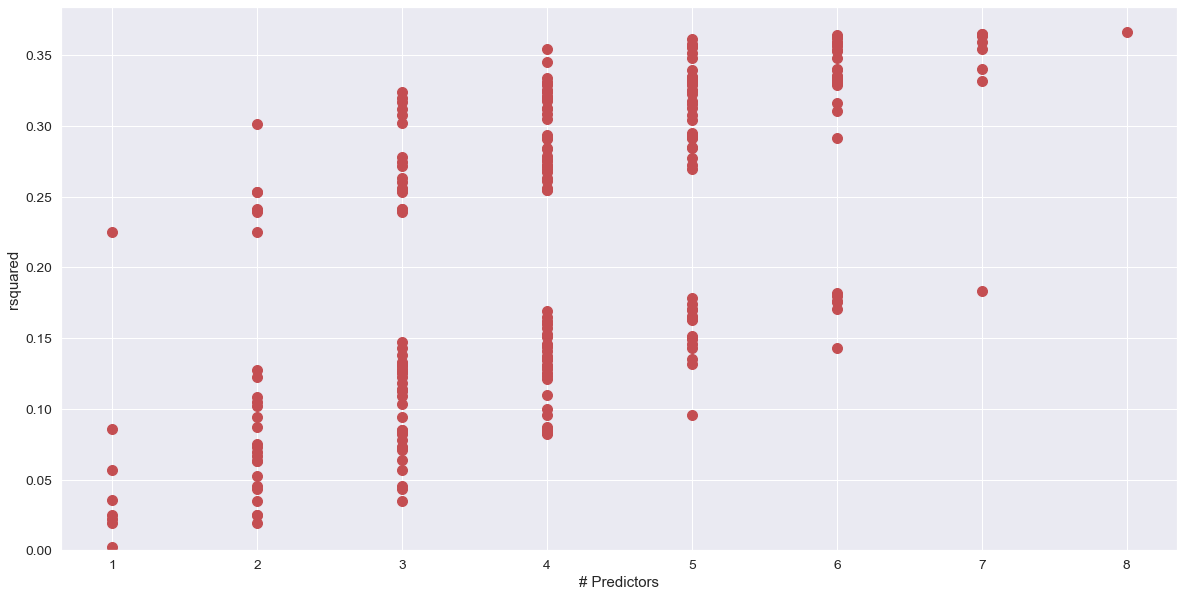

In [32]:
#Plots all generated models based on r-squared - clear separation is seen

def best_sub_plots():
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

    # Set up a 2x2 grid so we can look at 4 plots at once
    #plt.subplot(2, 2, 1)

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector
    plot_array = []
    for i in range(1, models_best.shape[0]+1):
        #print(i)
        models_made = models_best.loc[models_best['num_elements'] == i]['model'][i]
        for k in range(models_made.shape[0]):
            plot_array.append([i, models_made['model'], models_made['llr_pvalue'][k], models_made['vars'][k]])
        
    data = pd.DataFrame(plot_array, columns = ['num_elements', 'model', 'rsquared', 'vars'])
    plt.plot(data['num_elements'], data['rsquared'], 'ro')
    plt.xlabel('# Predictors')
    plt.ylabel('rsquared')
    plt.ylim(bottom=0)
    plt.savefig('rsquared_all_models.png')
    
    return data

all_models = best_sub_plots()

In [33]:
#Creates a datefram including the model, its psuedo r-squared, the variables considered, and booleans for whether a given variable was used

def new_col(var, dfr):
    return dfr['vars'].apply(lambda x: var in x)

for variable in list(X.columns):
    all_models[variable] = new_col(variable, all_models)    

In [34]:
#Shows the percentage of models including a given veriable when the pseudo r-squared is over 0.2 (boundary between regions)

all_models[all_models.rsquared > 0.2][list(X.columns)].sum()/all_models['Sex'].sum()

Pclass        0.525000
Sex           1.000000
Age           0.508333
SibSp         0.466667
Parch         0.508333
Fare          0.491667
Embarked      0.500000
age_binned    0.516667
dtype: float64

In [35]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

newdf = train_with_age[predictors].select_dtypes(include=numerics)

X_v = newdf.columns

In [36]:
#Checks correlation of all numeric values

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X_vif = add_constant(train_with_age[X_v])
vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns

for i in range(len(X_vif.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(X_vif.values, i)

print(vif_data)

  feature       VIF
0   const  5.950504
1     Age  1.011726
2    Fare  1.011726


C:\Users\david\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


## Developing the model

**All of the folllowing code produced by Hiba Khatib & Emily Leibfritz**

Try a basic model with only the variables that were deemed as relevant in the previous variable selection code.

In [37]:
final_train = train_with_age.copy()


In [38]:
# dropping the columns that we don't need
final_train = train_with_age.drop(columns = ['PassengerId', 'Name', 'Ticket'])

In [39]:
final_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,age_binned
0,0,3,male,22.0,1,0,7.2500,S,"(20.315, 30.263]"
1,1,1,female,38.0,1,0,71.2833,C,"(30.263, 40.21]"
2,1,3,female,26.0,0,0,7.9250,S,"(20.315, 30.263]"
3,1,1,female,35.0,1,0,53.1000,S,"(30.263, 40.21]"
4,0,3,male,35.0,0,0,8.0500,S,"(30.263, 40.21]"


In [40]:
# don't thinl we need to include this
# # basic statsmodel
# logit_model1 = sm.logit(formula = 'Survived~ Pclass + Sex + Age + SibSp + Parch + Fare + Embarked + age_binned', data = final_train).fit()
# logit_model1.summary()

In [41]:
# to work with sklearn, convert Sex, Embarked into dummie variables
final_train = pd.get_dummies(final_train, columns = ['Sex'], drop_first = True)
final_train = final_train.rename(columns={"Sex_1": "Sex"})
final_train.rename(columns={"Sex_male": "Sex"}, inplace = True)
final_train['Embarked'] = final_train['Embarked'].apply(lambda x: 1 if x == 'S' else 
                                                               2 if x == 'C' else 
                                                               0)
# final_train['Pclass'] = pd.to_numeric(final_train['Pclass'])
# final_train['SibSp'] = pd.to_numeric(final_train['SibSp'])
# final_train['Parch'] = pd.to_numeric(final_train['Parch'])

## done later in previous doc

final_train = final_train.drop('age_binned', axis = 1)


In [42]:
# split the data to test and train for sklearn model
y = final_train.Survived
X = final_train.drop('Survived', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 45)

In [43]:
sklearn_model = LogisticRegression(max_iter=500)
sklearn_model.fit(X_train, y_train)

LogisticRegression(max_iter=500)

In [44]:
y_pred_test = sklearn_model.predict(X_test)
print('Accuracy of logistic regression on test set : {:.4f}'.format(sklearn_model.score(X_test, y_test)))

Accuracy of logistic regression on test set : 0.7910


The first model with the basic, selected variables has an accuracy of 79.1%

### Polish that model by using extensive feature selection on all columns besides the ones discared in previous variable selection

In [45]:
def fit_logistic_reg(X,Y):
    #Fit linear regression model and return RSS and R squared values
    model_k = linear_model.LogisticRegression()
    model_k.fit(X,Y)
    RSS = mean_squared_error(Y,model_k.predict(X)) * len(Y)
    R_squared = model_k.score(X,Y)
    return RSS, R_squared

In [46]:
#Importing tqdm for the progress bar
from tqdm import tnrange, tqdm_notebook

k = 11
RSS_list, R_squared_list, feature_list = [],[], []
numb_features = []

#Looping over k = 1 to k = 11 features in X
for k in tnrange(1,len(X_train.columns) + 1, desc = 'Loop...'):

    #Looping over all possible combinations: from 11 choose k
    for combo in itertools.combinations(X_train.columns,k):
        tmp_result = fit_logistic_reg(X_train[list(combo)],y_train)   #Store temp result 
        RSS_list.append(tmp_result[0])                  #Append lists
        R_squared_list.append(tmp_result[1])
        feature_list.append(combo)
        numb_features.append(len(combo))   

#Store in DataFrame
df = pd.DataFrame({'numb_features': numb_features,'RSS': RSS_list, 'R_squared':R_squared_list,'features':feature_list})

C:\Users\david\AppData\Local\Temp/ipykernel_12568/3908137826.py:9: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(X_train.columns) + 1, desc = 'Loop...'):


Loop...:   0%|          | 0/7 [00:00<?, ?it/s]

C:\Users\david\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [47]:
df_min = df[df.groupby('numb_features')['RSS'].transform(min) == df['RSS']]
df_max = df[df.groupby('numb_features')['R_squared'].transform(max) == df['R_squared']]

In [48]:
df['min_RSS'] = df.groupby('numb_features')['RSS'].transform(min)
df['max_R_squared'] = df.groupby('numb_features')['R_squared'].transform(max)


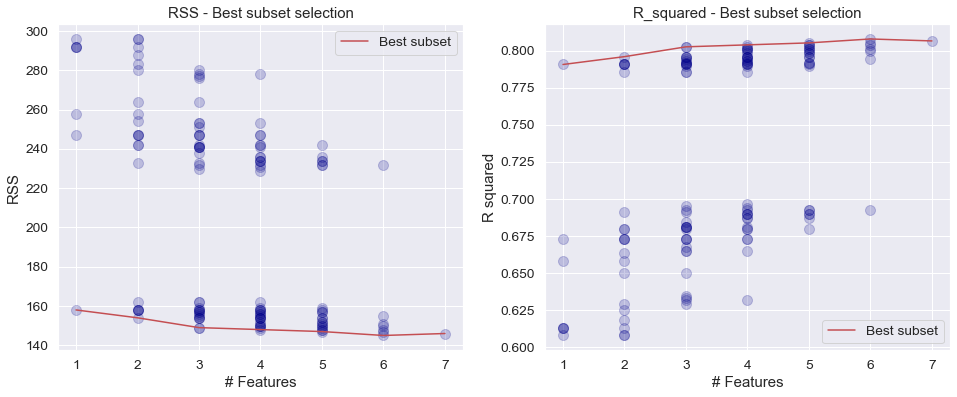

In [49]:
fig = plt.figure(figsize = (16,6))
ax = fig.add_subplot(1, 2, 1)

ax.scatter(df.numb_features,df.RSS, alpha = .2, color = 'darkblue' )
ax.set_xlabel('# Features')
ax.set_ylabel('RSS')
ax.set_title('RSS - Best subset selection')
ax.plot(df.numb_features,df.min_RSS,color = 'r', label = 'Best subset')
ax.legend()

ax = fig.add_subplot(1, 2, 2)
ax.scatter(df.numb_features,df.R_squared, alpha = .2, color = 'darkblue' )
ax.plot(df.numb_features,df.max_R_squared,color = 'r', label = 'Best subset')
ax.set_xlabel('# Features')
ax.set_ylabel('R squared')
ax.set_title('R_squared - Best subset selection')
ax.legend()

plt.show()

In [50]:
df[(df["numb_features"] == 6)].sort_values(by = ['R_squared'], ascending=False)

,numb_features,RSS,R_squared,features,min_RSS,max_R_squared
121,6,145.0,0.807947,"(Pclass, Age, SibSp, Parch, Embarked, Sex)",145.0,0.807947
122,6,147.0,0.805298,"(Pclass, Age, SibSp, Fare, Embarked, Sex)",145.0,0.807947
120,6,148.0,0.803974,"(Pclass, Age, SibSp, Parch, Fare, Sex)",145.0,0.807947
123,6,150.0,0.801325,"(Pclass, Age, Parch, Fare, Embarked, Sex)",145.0,0.807947
124,6,151.0,0.800000,"(Pclass, SibSp, Parch, Fare, Embarked, Sex)",145.0,0.807947
125,6,155.0,0.794702,"(Age, SibSp, Parch, Fare, Embarked, Sex)",145.0,0.807947
119,6,232.0,0.692715,"(Pclass, Age, SibSp, Parch, Fare, Embarked)",145.0,0.807947


In [51]:
df[(df["numb_features"] == 7)].sort_values(by = ['R_squared'], ascending=False)

,numb_features,RSS,R_squared,features,min_RSS,max_R_squared
126,7,146.0,0.806623,"(Pclass, Age, SibSp, Parch, Fare, Embarked, Sex)",146.0,0.806623


When the number of features is 6, the RSS is minimized and the R squared is maximized. This improves the fit of the model. The features that improve the model the best are (**Pclass, Age, SibSp, Parch, Embarked, Sex**). This means we are dropping the Fare cost.

In [52]:
# Build a model using those variables
X_train = X_train.drop('Fare', axis = 1)
X_test = X_test.drop('Fare', axis = 1)
sklearn_model = LogisticRegression()
sklearn_model.fit(X_train, y_train)

y_pred_test = sklearn_model.predict(X_test)
print('Accuracy of logistic regression on test set : {:.4f}'.format(sklearn_model.score(X_test, y_test)))

Accuracy of logistic regression on test set : 0.7985


### look for interactions manually

In [53]:
final_train['SibSp'] = pd.to_numeric(final_train['SibSp'])
final_train['Parch'] = pd.to_numeric(final_train['Parch'])
final_train['Pclass'] = pd.to_numeric(final_train['Pclass'])

<AxesSubplot:>

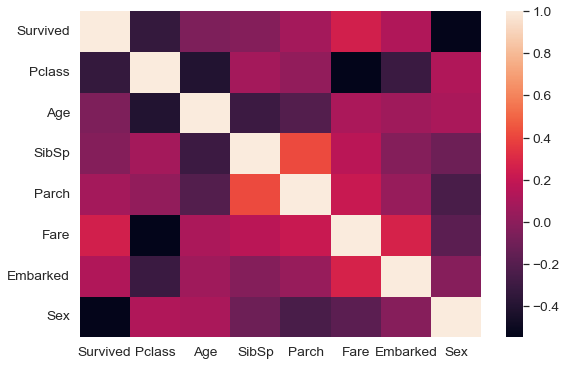

In [54]:
sns.heatmap(final_train.corr())

Possible interaction terms:

AgexPclass 

SibSpXParch

PclassXEmbarked?

In [55]:
X_train1 = X_train.copy()
X_train1['agePclass']= final_train.Age * final_train.Pclass
X_train1['ParchSibSp']= final_train.SibSp * final_train.Parch
X_train1['EmbarkedPclass']= final_train.Embarked * final_train.Pclass


In [56]:
X_test1 = X_test.copy()
X_test1['Parch'] = pd.to_numeric(X_test1.Parch)
X_test1['SibSp'] = pd.to_numeric(X_test1.SibSp)
X_test1['Pclass'] = pd.to_numeric(X_test1.Pclass)
X_test1['agePclass']= X_test1.Age * X_test1.Pclass
X_test1['ParchSibSp']= X_test1.SibSp * X_test1.Parch
X_test1['EmbarkedPclass']= X_test1.Embarked * X_test1.Pclass

In [57]:
# make model using these
sklearn_model_1 = LogisticRegression()
sklearn_model_1.fit(X_train1, y_train)

C:\Users\david\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [58]:
y_pred_test = sklearn_model_1.predict(X_test1)
print('Accuracy of logistic regression on test set : {:.4f}'.format(sklearn_model_1.score(X_test1, y_test)))

Accuracy of logistic regression on test set : 0.8060


In [59]:
sklearn_model_1.coef_

array([[-0.13427152, -0.01206869,  0.07573075,  0.16884276,  1.22124432,
        -2.51777338, -0.01116337, -0.31921879, -0.39676533]])

In [60]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.87      0.83      0.85        86
           1       0.71      0.77      0.74        48

    accuracy                           0.81       134
   macro avg       0.79      0.80      0.79       134
weighted avg       0.81      0.81      0.81       134



### Improve more by using forward variable selection including 2 fold interactions between columns

In [61]:
# reload entire data
# split the data to test and train for sklearn model again bc X_train now includes all interactions
final_train = train_with_age.copy()
final_train = train_with_age.drop(columns = ['PassengerId', 'Name', 'Ticket'])
# to work with sklearn, convert Sex, Embarked into dummie variables
final_train = pd.get_dummies(final_train, columns = ['Sex'], drop_first = True)
final_train = final_train.rename(columns={"Sex_1": "Sex"})
final_train.rename(columns={"Sex_male": "Sex"}, inplace = True)
final_train['Embarked'] = final_train['Embarked'].apply(lambda x: 1 if x == 'S' else 
                                                               2 if x == 'C' else 
                                                               0)
final_train['Pclass'] = pd.to_numeric(final_train['Pclass'])
final_train['SibSp'] = pd.to_numeric(final_train['SibSp'])
final_train['Parch'] = pd.to_numeric(final_train['Parch'])
final_train = final_train.drop('age_binned', axis = 1)
y = final_train.Survived
X = final_train.drop('Survived', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 45)

In [62]:
#Creating a dataframe with all the predictors
X = X_train
#Since 'X' will change when we include interactions, we need a backup containing all individual predictors
X_backup = X_train

# make test dataframe
final_test = pd.concat([X_test.reset_index(drop=True),y_test.reset_index(drop=True)], axis=1)

In [63]:
#Including 2-factor interactions of predictors in train and 'X'. Note that we need train to develop the model, and X to 
#find 'k' variable subsets from amongst all the predictors under consideration
for combo in itertools.combinations(X_backup.columns, 2):    
    final_train['_'.join(combo)] = final_train[combo[0]]*final_train[combo[1]]
    final_test['_'.join(combo)] = final_test[combo[0]]*final_test[combo[1]]
    X.loc[:,'_'.join(combo)] = final_train.loc[:,'_'.join(combo)] 

In [64]:
#Initialization variables
k = 11

remaining_features = list(X.columns.values)
features = []
RSS_list, R_squared_list = [np.inf], [np.inf] #Due to 1 indexing of the loop...
features_list = dict()

for i in range(1,k+1):
    best_RSS = np.inf
    
    for combo in itertools.combinations(remaining_features,1):

            RSS = fit_logistic_reg(X[list(combo) + features],y_train)   #Store temp result 

            if RSS[0] < best_RSS:
                best_RSS = RSS[0]
                best_R_squared = RSS[1] 
                best_feature = combo[0]

    #Updating variables for next loop
    features.append(best_feature)
    remaining_features.remove(best_feature)
    
    #Saving values for plotting
    RSS_list.append(best_RSS)
    R_squared_list.append(best_R_squared)
    features_list[i] = features.copy()

C:\Users\david\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\david\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

C:\Users\david\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\david\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

C:\Users\david\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\david\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

C:\Users\david\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\david\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

In [65]:
df1 = pd.concat([pd.DataFrame({'features':features_list}),pd.DataFrame({'RSS':RSS_list, 'R_squared': R_squared_list})], axis=1, join='inner')
df1['numb_features'] = df1.index
#Initializing useful variables
m = len(y_train)
p = 11
hat_sigma_squared = (1/(m - p -1)) * min(df1['RSS'])

#Computing
df1['C_p'] = (1/m) * (df1['RSS'] + 2 * df1['numb_features'] * hat_sigma_squared )
df1['AIC'] = (1/(m*hat_sigma_squared)) * (df1['RSS'] + 2 * df1['numb_features'] * hat_sigma_squared )
df1['BIC'] = (1/(m*hat_sigma_squared)) * (df1['RSS'] +  np.log(m) * df1['numb_features'] * hat_sigma_squared )
df1['R_squared_adj'] = 1 - ( (1 - df1['R_squared'])*(m-1)/(m-df1['numb_features'] -1))
df1.head(3)

,features,RSS,R_squared,numb_features,C_p,AIC,BIC,R_squared_adj
1,[Age_Sex],154.0,0.796026,1,0.204401,1.265585,1.271713,0.795756
2,"[Age_Sex, Pclass_SibSp]",135.0,0.821192,2,0.179664,1.112417,1.124673,0.820716
3,"[Age_Sex, Pclass_SibSp, Age_Parch]",131.0,0.826490,3,0.174793,1.082263,1.100647,0.825797


### Best Model according to BIC

In [66]:
# best according to BIC
df1.iloc[df1.BIC.argmin(),0]

['Age_Sex',
 'Pclass_SibSp',
 'Age_Parch',
 'Parch_Embarked',
 'Pclass_Parch',
 'Parch_Fare',
 'Age_SibSp',
 'Parch']

In [67]:
# create X_train for best by BIC
X_train_int = X[['Age_Sex','Pclass_SibSp','Pclass_Embarked','Parch','Age_Parch','SibSp','Pclass_Parch','Fare_Sex']]
# make this for X_test as well
X_test_int = final_test[['Age_Sex','Pclass_SibSp','Pclass_Embarked','Parch','Age_Parch','SibSp','Pclass_Parch','Fare_Sex']]

sklearn_model_int = LogisticRegression()
sklearn_model_int.fit(X_train_int, y_train)

C:\Users\david\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [68]:
y_pred_test_int = sklearn_model_int.predict(X_test_int)
print('Accuracy of logistic regression on test set : {:.4f}'.format(sklearn_model_int.score(X_test_int, y_test)))

Accuracy of logistic regression on test set : 0.8209


In [69]:
print(classification_report(y_test, y_pred_test_int))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86        86
           1       0.77      0.71      0.74        48

    accuracy                           0.82       134
   macro avg       0.81      0.80      0.80       134
weighted avg       0.82      0.82      0.82       134



## Performance Measurmenet

In [70]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred_test) 
print ("Confusion Matrix : \n", cm) 
  
# accuracy score of the model
print('Test accuracy = ', accuracy_score(y_test, y_pred_test_int))

Confusion Matrix : 
 [[71 15]
 [11 37]]
Test accuracy =  0.8208955223880597


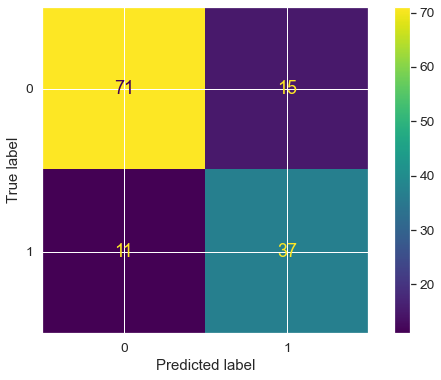

In [71]:
# should we remove this?
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=sklearn_model_1.classes_)
disp.plot()

plt.show()

C:\Users\david\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


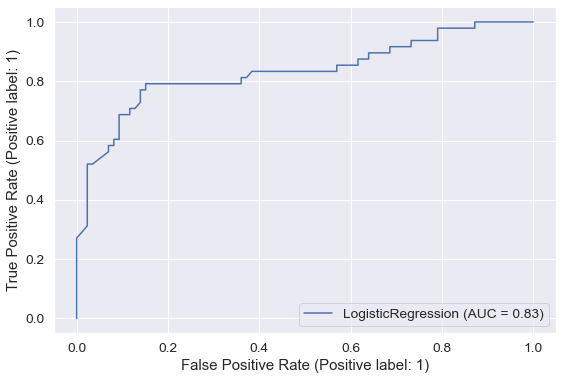

In [72]:
from sklearn import datasets, metrics, model_selection, svm
metrics.plot_roc_curve(sklearn_model_int, X_test_int, y_test)
plt.show()

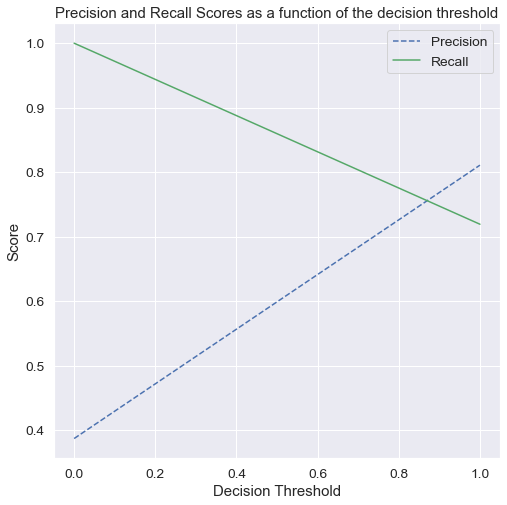

In [73]:
ypred_int = sklearn_model_int.predict(X_train_int)
from sklearn.metrics import precision_recall_curve

y = y_train
# ypred = logit_model_diabetes.predict(train)
p, r, thresholds = precision_recall_curve(y, ypred_int)
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()
plot_precision_recall_vs_threshold(p, r, thresholds)

# !!!! Ignore everything under here, can be deleted if top runs!!!

# SKIP

# Variable selection with interactions p

In [74]:
#Creating a dataframe with all the predictors
X = X_train
#Since 'X' will change when we include interactions, we need a backup containing all individual predictors
X_backup = X_train

In [75]:
# make test dataframe
final_test = pd.concat([X_test.reset_index(drop=True),y_test.reset_index(drop=True)], axis=1)

In [76]:
#Including 2-factor interactions of predictors in train and 'X'. Note that we need train to develop the model, and X to 
#find 'k' variable subsets from amongst all the predictors under consideration
for combo in itertools.combinations(X_backup.columns, 2):    
    final_train['_'.join(combo)] = final_train[combo[0]]*final_train[combo[1]]
    final_test['_'.join(combo)] = final_test[combo[0]]*final_test[combo[1]]
    X.loc[:,'_'.join(combo)] = final_train.loc[:,'_'.join(combo)] 

KeyError: 'Age_SibSp'

### run forward Selection

In [ ]:
def fit_logistic_reg(X,Y):
    #Fit logistic regression model and return RSS and R squared values
    #model_k = linear_model.LinearRegression()
    model_k = LogisticRegression(max_iter=500)
    model_k.fit(X,Y)
    RSS = mean_squared_error(Y,model_k.predict(X)) * len(Y)
    R_squared = model_k.score(X,Y)
    return RSS, R_squared

In [ ]:
#Initialization variables
k = 11

remaining_features = list(X.columns.values)
features = []
RSS_list, R_squared_list = [np.inf], [np.inf] #Due to 1 indexing of the loop...
features_list = dict()

for i in range(1,k+1):
    best_RSS = np.inf
    
    for combo in itertools.combinations(remaining_features,1):

            RSS = fit_logistic_reg(X[list(combo) + features],y_train)   #Store temp result 

            if RSS[0] < best_RSS:
                best_RSS = RSS[0]
                best_R_squared = RSS[1] 
                best_feature = combo[0]

    #Updating variables for next loop
    features.append(best_feature)
    remaining_features.remove(best_feature)
    
    #Saving values for plotting
    RSS_list.append(best_RSS)
    R_squared_list.append(best_R_squared)
    features_list[i] = features.copy()

In [ ]:
df1 = pd.concat([pd.DataFrame({'features':features_list}),pd.DataFrame({'RSS':RSS_list, 'R_squared': R_squared_list})], axis=1, join='inner')
df1['numb_features'] = df1.index

In [ ]:
#Initializing useful variables
m = len(y_train)
p = 11
hat_sigma_squared = (1/(m - p -1)) * min(df1['RSS'])

#Computing
df1['C_p'] = (1/m) * (df1['RSS'] + 2 * df1['numb_features'] * hat_sigma_squared )
df1['AIC'] = (1/(m*hat_sigma_squared)) * (df1['RSS'] + 2 * df1['numb_features'] * hat_sigma_squared )
df1['BIC'] = (1/(m*hat_sigma_squared)) * (df1['RSS'] +  np.log(m) * df1['numb_features'] * hat_sigma_squared )
df1['R_squared_adj'] = 1 - ( (1 - df1['R_squared'])*(m-1)/(m-df1['numb_features'] -1))
df1.head(3)

In [ ]:
# best according to BIC
df1.iloc[df1.BIC.argmin(),0]

In [ ]:
# Best according to AIC
df1.iloc[df1.AIC.argmin(),0]

In [ ]:
# create X_train for best by BIC
X_train_int = X[['Age_Sex','Pclass_SibSp','Pclass_Embarked','Parch','Age_Parch','SibSp','Pclass_Parch','Fare_Sex']]
# make this for X_test as well
X_test_int = final_test[['Age_Sex','Pclass_SibSp','Pclass_Embarked','Parch','Age_Parch','SibSp','Pclass_Parch','Fare_Sex']]

In [ ]:
sklearn_model_int = LogisticRegression()
sklearn_model_int.fit(X_train_int, y_train)


In [ ]:
y_pred_test = sklearn_model_int.predict(X_test_int)
print('Accuracy of logistic regression on test set : {:.4f}'.format(sklearn_model_int.score(X_test_int, y_test)))

# Use Extensive Feature  Selection without interactions

In [ ]:
# def fit_logistic_reg(X,Y):
#     #Fit linear regression model and return RSS and R squared values
#     model_k = linear_model.LogisticRegression()
#     model_k.fit(X,Y)
#     RSS = mean_squared_error(Y,model_k.predict(X)) * len(Y)
#     R_squared = model_k.score(X,Y)
#     return RSS, R_squared

In [ ]:
# split the data to test and train for sklearn model again bc X_train now includes all interactions
final_train = train_with_age.copy()
final_train = train_with_age.drop(columns = ['PassengerId', 'Name', 'Ticket', 'Cabin'])
# to work with sklearn, convert Sex, Embarked into dummie variables
final_train = pd.get_dummies(final_train, columns = ['Sex'], drop_first = True)
final_train = final_train.rename(columns={"Sex_1": "Sex"})
final_train.rename(columns={"Sex_male": "Sex"}, inplace = True)
final_train['Embarked'] = final_train['Embarked'].apply(lambda x: 1 if x == 'S' else 
                                                               2 if x == 'C' else 
                                                               0)
final_train['Pclass'] = pd.to_numeric(final_train['Pclass'])
final_train['SibSp'] = pd.to_numeric(final_train['SibSp'])
final_train['Parch'] = pd.to_numeric(final_train['Parch'])
final_train = final_train.drop('age_binned', axis = 1)
y = final_train.Survived
X = final_train.drop('Survived', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 45)

In [ ]:
k = 11
RSS_list, R_squared_list, feature_list = [],[], []
numb_features = []

#Looping over k = 1 to k = 11 features in X
for k in tnrange(1,len(X_train.columns) + 1, desc = 'Loop...'):

    #Looping over all possible combinations: from 11 choose k
    for combo in itertools.combinations(X_train.columns,k):
        tmp_result = fit_logistic_reg(X_train[list(combo)],y_train)   #Store temp result 
        RSS_list.append(tmp_result[0])                  #Append lists
        R_squared_list.append(tmp_result[1])
        feature_list.append(combo)
        numb_features.append(len(combo))   

#Store in DataFrame
df = pd.DataFrame({'numb_features': numb_features,'RSS': RSS_list, 'R_squared':R_squared_list,'features':feature_list})

In [ ]:
df_min = df[df.groupby('numb_features')['RSS'].transform(min) == df['RSS']]
df_max = df[df.groupby('numb_features')['R_squared'].transform(max) == df['R_squared']]
display(df_min.head(10))
display(df_max.head(10))

In [ ]:
df['min_RSS'] = df.groupby('numb_features')['RSS'].transform(min)
df['max_R_squared'] = df.groupby('numb_features')['R_squared'].transform(max)
df.head()

In [ ]:
fig = plt.figure(figsize = (16,6))
ax = fig.add_subplot(1, 2, 1)

ax.scatter(df.numb_features,df.RSS, alpha = .2, color = 'darkblue' )
ax.set_xlabel('# Features')
ax.set_ylabel('RSS')
ax.set_title('RSS - Best subset selection')
ax.plot(df.numb_features,df.min_RSS,color = 'r', label = 'Best subset')
ax.legend()

ax = fig.add_subplot(1, 2, 2)
ax.scatter(df.numb_features,df.R_squared, alpha = .2, color = 'darkblue' )
ax.plot(df.numb_features,df.max_R_squared,color = 'r', label = 'Best subset')
ax.set_xlabel('# Features')
ax.set_ylabel('R squared')
ax.set_title('R_squared - Best subset selection')
ax.legend()

plt.show()

In [ ]:
df[(df["numb_features"] == 6)].sort_values(by = ['R_squared'], ascending=False)

In [ ]:
df[(df["numb_features"] == 7)].sort_values(by = ['R_squared'], ascending=False)

### Selected variables: (Pclass, Age, SibSp, Parch, Embarked, Sex)	


In [ ]:
X_train = X_train.drop('Fare', axis = 1)
X_test = X_test.drop('Fare', axis = 1)

In [ ]:
sklearn_model = LogisticRegression()
sklearn_model.fit(X_train, y_train)

y_pred_test = sklearn_model.predict(X_test)
print('Accuracy of logistic regression on test set : {:.4f}'.format(sklearn_model.score(X_test, y_test)))

In [ ]:
# final_train['SibSp'] = pd.to_numeric(final_train['SibSp'])
# final_train['Parch'] = pd.to_numeric(final_train['Parch'])
# final_train['Pclass'] = pd.to_numeric(final_train['Pclass'])

In [ ]:
# Interacation between SibSp and Parch

def jitter(values,j):
    return values + np.random.normal(j,0.02,values.shape)
sns.scatterplot(x=jitter(final_train.SibSp,0), y = jitter(final_train.Parch,0),data = final_train, color = 'orange')

In [ ]:
# SibSP
sns.scatterplot(x = jitter(final_train.SibSp,0), y = jitter(final_train.Survived,0), color = 'orange')
model = smf.logit(formula = 'Survived~SibSp', data = final_train).fit()
sns.lineplot(x = 'SibSp', y= model.predict(final_train), data = final_train, color = 'blue') 
model.llf

In [ ]:
# SibSP squared
sns.scatterplot(x = jitter(final_train.SibSp,0), y = jitter(final_train.Survived,0), color = 'orange')
model = smf.logit(formula = 'Survived~SibSp+I(SibSp**2)', data = final_train).fit()
sns.lineplot(x = 'SibSp', y= model.predict(final_train), data = final_train, color = 'blue') 
model.llf

In [ ]:
# Parch
sns.scatterplot(x = jitter(final_train.Parch,0), y = jitter(final_train.Survived,0), color = 'orange')
model = smf.logit(formula = 'Survived~Parch', data = final_train).fit()
sns.lineplot(x = 'Parch', y= model.predict(final_train), data = final_train, color = 'blue') 
model.llf

In [ ]:
# Parch squared
sns.scatterplot(x = jitter(final_train.Parch,0), y = jitter(final_train.Survived,0), color = 'orange')
model = smf.logit(formula = 'Survived~Parch+I(Parch**2)', data = final_train).fit()
sns.lineplot(x = 'Parch', y= model.predict(final_train), data = final_train, color = 'blue') 
model.llf

In [ ]:
# age not binned
sns.scatterplot(x = jitter(final_train.Age,0), y = jitter(final_train.Survived,0), color = 'orange')
model = smf.logit(formula = 'Survived~Age', data = final_train).fit()
sns.lineplot(x = 'Age', y= model.predict(final_train), data = final_train, color = 'blue') 
model.llf

In [ ]:
# age squared
sns.scatterplot(x = jitter(final_train.Age,0), y = jitter(final_train.Survived,0), color = 'orange')
model = smf.logit(formula = 'Survived~Age+I(Age**2)', data = final_train).fit()
sns.lineplot(x = 'Age', y= model.predict(final_train), data = final_train, color = 'blue') 
model.llf

In [ ]:
X_train1 = X_train.copy()
#X_train1['Age_binned'] = train_with_age['age_binned']
X_train1['agePclass']= final_train.Age * final_train.Pclass
X_train1['ParchSibSp']= final_train.SibSp * final_train.Parch
X_train1['EmbarkedPclass']= final_train.Embarked * final_train.Pclass
#X_train1 = X_train1.drop(['Age_binned'], axis = 1)

In [ ]:
X_test1 = X_test.copy()
X_test1['Parch'] = pd.to_numeric(X_test1.Parch)
X_test1['SibSp'] = pd.to_numeric(X_test1.SibSp)
X_test1['Pclass'] = pd.to_numeric(X_test1.Pclass)
X_test1['agePclass']= X_test1.Age * X_test1.Pclass
X_test1['ParchSibSp']= X_test1.SibSp * X_test1.Parch
X_test1['EmbarkedPclass']= X_test1.Embarked * X_test1.Pclass

In [ ]:
X_test1

### Code fitting the final model

Put the code(s) that fit the final model(s) in separate cell(s), i.e., the code with the `.ols()` or `.logit()` functions.

In [ ]:
sklearn_model_1 = LogisticRegression()
sklearn_model_1.fit(X_train1, y_train)


In [ ]:
y_pred_test = sklearn_model_1.predict(X_test1)
print('Accuracy of logistic regression on test set : {:.4f}'.format(sklearn_model_1.score(X_test1, y_test)))

In [ ]:
print(classification_report(y_test, y_pred_test))

### Performance Measurement 

In [ ]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred_test) 
print ("Confusion Matrix : \n", cm) 
  
# accuracy score of the model
print('Test accuracy = ', accuracy_score(y_test, y_pred_test))

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=sklearn_model_1.classes_)
disp.plot()

plt.show()

In [ ]:
metrics.plot_roc_curve(sklearn_model_1, X_test1, y_test)
plt.show()

In [ ]:
ypred = sklearn_model_1.predict(X_train1)
y = y_train
# ypred = logit_model_diabetes.predict(train)
p, r, thresholds = precision_recall_curve(y, ypred)
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()
plot_precision_recall_vs_threshold(p, r, thresholds)

## Model Summary, Coefficients and P-Values

David Ventor

In [ ]:
X_train1.columns

In [ ]:
final_model = sm.logit('Survived~Pclass+Age+SibSp+Parch+Embarked+Sex+Age*Pclass+Embarked*Pclass',data = train_with_age).fit()
final_model.summary()

## Conclusions and Recommendations to stakeholder(s)

# You may or may not have code to put in this section. Delete this section if it is irrelevant.

As we are analyzing a historical event, we do not have any recommendations to present as there are no stakeholders that would significantly benefit from our insights. 

In terms of conclusions, out optimized logistic model summary shows the factors that were the most impactful. The first thing that stands out, as it did throughout our analysis, was the impact of sex on survival. The coefficient for male was -2.7381, with a p-value rounding to ~0. This shows the that the stereotypical prioritization of women in survival situtations is historically accurate, with female survival rate being significantly higher. The second thing, that once again was in line with our expectations, was the dependance on class. The intercept coefficent, corresponding to class 1 passengers, has coefficent of 4.0693 with a p-value ~0 showing that the upper class passengers where able to survive at a significantly higher rate, especially compared to 3rd class (ceof = -1.9166, pval = 0.009). Interestingly the second class coefficient was not singificant, highlighting the gap between the highest and lowest class.

Another aspect that we expected to be significant was Age, to emphasize the expression 'women and children first' that was frequently stated in the movie, and is stereotypical of emergency situations even today. We were able to find a significant decrease in survival with Age (pval = 0.008), but the coefficient was just -0.0349, a lower impact than expected. Bucketing age did not appear useful, although in early analysis showed that this trend (lower survival with age) is not consistent across age groups. Another factor that may give insight into this area is the factors SubSp, and Parch, which show the number of siblings aboard and number of parents and children. The former was shown to have a moderate impact of -0.3319, with a pvalue 0.004. This indicates that larger families (children on board with more siblings) had more difficulty surviving, potentially skewing the age to have less impact than expected. 

Other factors lead to improved modeling outcomes, but did not carry significant in the model, making their impact less intuitive to understand. In general our analysis found that the stereotypical prioritization of women and children appears to exist, but gender seems to be a much larger predictor than age. Class was shown to be second only to gender, showing how even in crisis, those with higher class are able to secure better outcomes. These factors give insight into human nature, and confirm many aspects of people are traditional thought to react in emergencies. 

Overall, our model stil has shortcomings, with a recall of just 0.68, showing the difficulty in correctly identifying survived passengers when a clear majority did not survie, and in an emergency situation things are inherently unpredictable, to a degree. If this model were to be improved further, the focus would be on the precisions and recall for the survival values, as those are the minority. 